<a href="https://colab.research.google.com/github/msrepo/2d3d/blob/master/day3_image_reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. clone repo

In [ ]:
!git clone https://github.com/RISE-MICCAI/AI-in-Medical-Imaging-Winter-2022-School.git

Cloning into 'AI-in-Medical-Imaging-Winter-2022-School'...
remote: Enumerating objects: 144, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 144 (delta 16), reused 25 (delta 9), pack-reused 105
Receiving objects: 100% (144/144), 47.61 MiB | 25.14 MiB/s, done.
Resolving deltas: 100% (66/66), done.


In [ ]:
!pip install SimpleITK

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 52.8 MB 189 kB/s 


In [ ]:
!pip install torch==1.10.1+cu102 torchvision==0.11.2+cu102 torchaudio==0.10.1 -f https://download.pytorch.org/whl/cu102/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/cu102/torch_stable.html
     |██████████████████████████████▎ | 834.1 MB 1.3 MB/s eta 0:00:37tcmalloc: large alloc 1147494400 bytes == 0x38bf2000 @  0x7fa8bb861615 0x58ead6 0x4f355e 0x4d222f 0x51041f 0x5b4ee6 0x58ff2e 0x510325 0x5b4ee6 0x58ff2e 0x50d482 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4bac0a 0x538a76 0x590ae5 0x510280 0x5b4ee6 0x58ff2e 0x50d482 0x5b4ee6 0x58ff2e 0x50c4fc 0x58fd37 0x50ca37 0x5b4ee6 0x58ff2e
     |████████████████████████████████| 881.9 MB 16 kB/s 
     |████████████████████████████████| 23.2 MB 54.5 MB/s 
     |████████████████████████████████| 2.9 MB 60.1 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
  Attempting uninstall: torchvision
    Found existing installation: tor

# 2. Imports

In [ ]:
import sys
sys.path.append("/content/AI-in-Medical-Imaging-Winter-2022-School/Supervised image registration using DL (D3)/Code")

import SimpleITK as sitk
import torch
from timeit import default_timer
from Reg_Tools import *

 
from uEpdiff import *
import matplotlib.pyplot as plt


model_path="/content/AI-in-Medical-Imaging-Winter-2022-School/Supervised image registration using DL (D3)/Code/PretrainedReg.tar"
data_directory = "/content/AI-in-Medical-Imaging-Winter-2022-School/Supervised image registration using DL (D3)/Test_3Ddata"

# 3. plot the data

In [ ]:
src = "/content/AI-in-Medical-Imaging-Winter-2022-School/Supervised image registration using DL (D3)/Test_3Ddata/src3d/src1.mhd"
tar = "/content/AI-in-Medical-Imaging-Winter-2022-School/Supervised image registration using DL (D3)/Test_3Ddata/tar3d/tar1.mhd"
tar_row = "/content/AI-in-Medical-Imaging-Winter-2022-School/Supervised image registration using DL (D3)/Test_3Ddata/tar3d/tar1.raw"


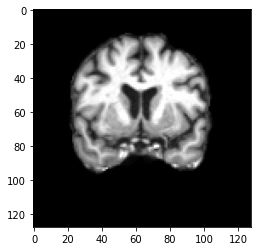

In [ ]:

itk_img = sitk.ReadImage(src) 
img_array = sitk.GetArrayFromImage(itk_img)
plt.imshow(img_array[80], cmap=plt.cm.gray, clim=np.percentile(img_array, (1,99)))
plt.show()


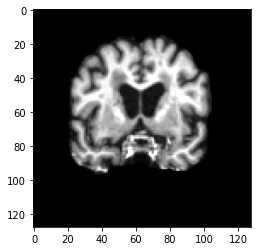

In [ ]:
itk_img = sitk.ReadImage(tar) 
img_array = sitk.GetArrayFromImage(itk_img)
plt.imshow(img_array[80], cmap=plt.cm.gray, clim=np.percentile(img_array, (1,99)))
plt.show()

# 4. code

In [ ]:
import SimpleITK as sitk
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
device = torch.device(dev)

imagesize = 128 
truncate = 16

net = getUnetT3D()
model_path = "/content/AI-in-Medical-Imaging-Winter-2022-School/Supervised image registration using DL (D3)/Code/PretrainedReg.tar"
data_directory = "/content/AI-in-Medical-Imaging-Winter-2022-School/Supervised image registration using DL (D3)/Test_3Ddata"

loadParameter(net, model_path, device=device)   #e.g., '/home/wn/qs/modelUNET3D/PretrainedReg.tar',
net = net.to(device)

with torch.no_grad():
    #  Load source and target image, and then predict momentum through neural network
    src = sitk.GetArrayFromImage(sitk.ReadImage(data_directory+"/src3d/src1.mhd")) #(128, 128, 128)
    tar = sitk.GetArrayFromImage(sitk.ReadImage(data_directory+"/tar3d/tar1.mhd")) #(128, 128, 128)
    src = torch.from_numpy(src).to(device);
    tar = torch.from_numpy(tar).to(device)

    """ 
    Transpose the axis
    done because I transpose them(source,target,momentum ground truth) during the training process,
    but its not necessary if you don't transpose them during the training process 
    """
    src_trans = src.permute(2,1,0).unsqueeze(0); 
    tar_trans = tar.permute(2,1,0).unsqueeze(0)
    inputs_val = torch.stack((src_trans,tar_trans),dim=1)  ##[1, 2, 128, 128, 128]
    print(inputs_val.shape)
    outputs_val = net(inputs_val)  #[1, 3, 128, 128, 128]
    momentum = outputs_val.permute(0,4,3,2,1)
    # outputs_val = outputs_val.detach().cpu().numpy()  #
    # outputs_val = np.transpose(outputs_val,[0,4,3,2,1])   #1,128,128,128,3

    

torch.Size([1, 2, 128, 128, 128])


# Solution

In [ ]:
##################   start shooting and deform  #######################






/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:282: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  ../aten/src/ATen/native/Copy.cpp:244.)


torch.Size([128, 128, 128, 3])


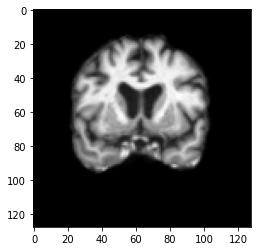

In [ ]:
src = "/content/AI-in-Medical-Imaging-Winter-2022-School/Supervised image registration using DL (D3)/Test_3Ddata/src3d/src1.mhd"
tar = "/content/AI-in-Medical-Imaging-Winter-2022-School/Supervised image registration using DL (D3)/Test_3Ddata/tar3d/tar1.mhd"
tar_row = "/content/AI-in-Medical-Imaging-Winter-2022-School/Supervised image registration using DL (D3)/Test_3Ddata/tar3d/tar1.raw"


traget = sitk.ReadImage(tar) 
traget = sitk.GetArrayFromImage(traget)

src = sitk.ReadImage(src) 
src = sitk.GetArrayFromImage(src)


output = dfm.cpu().numpy()
output = np.squeeze(output, 0)
output = np.squeeze(output, 0)
plt.imshow(output[80], cmap=plt.cm.gray)
plt.show()

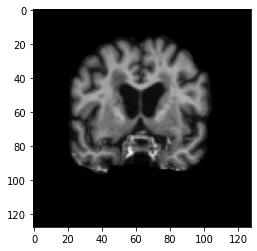

In [ ]:
plt.imshow(traget[80], cmap=plt.cm.gray)
plt.show()

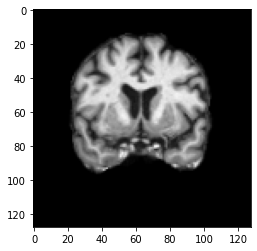

In [ ]:
plt.imshow(src[80], cmap=plt.cm.gray)
plt.show()